# One vs One and One vs Rest

Dataset: https://www.kaggle.com/datasets/burak3ergun/loan-data-set

1. Load the dataset -- 0.5 marks
2. Analyze the dataset -- 0.5 marks
3. Clean the dataset -- 0.5 marks
4. EDA --  1 mark
5. Split, standarzdize and encode -- 4 marks
6. Perform OvsO and OvsR -- 0.5 marks
7. Evaluate -- 0.5 marks
8. Analyze -- 2.5 marks

### Documentation:

OnevsOne: https://scikit-learn.org/dev/modules/generated/sklearn.multiclass.OneVsOneClassifier.html

One vs Rest: https://scikit-learn.org/1.5/modules/generated/sklearn.multiclass.OneVsRestClassifier.html


Reference:
https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/

In [6]:
!pip install kagglehub

In [8]:
import kagglehub

path = kagglehub.dataset_download("burak3ergun/loan-data-set")

print("Path to dataset files:", path)

100%|██████████| 7.80k/7.80k [00:00<00:00, 4.44MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/burak3ergun/loan-data-set/versions/1


In [10]:
!mv /root/.cache/kagglehub/datasets/burak3ergun/loan-data-set/versions/1/* .

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

In [63]:
df = pd.read_csv('loan_data_set.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [14]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [16]:
print(f"Shape of dataset: {df.shape}")
print("Null values:\n", df.isnull().sum())

Shape of dataset: (614, 13)
Null values:
 Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


In [26]:
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


Number of outliers in ApplicantIncome: 50
Number of outliers in CoapplicantIncome: 18
Number of outliers in LoanAmount: 39
Number of outliers in Loan_Amount_Term: 88
Number of outliers in Credit_History: 89


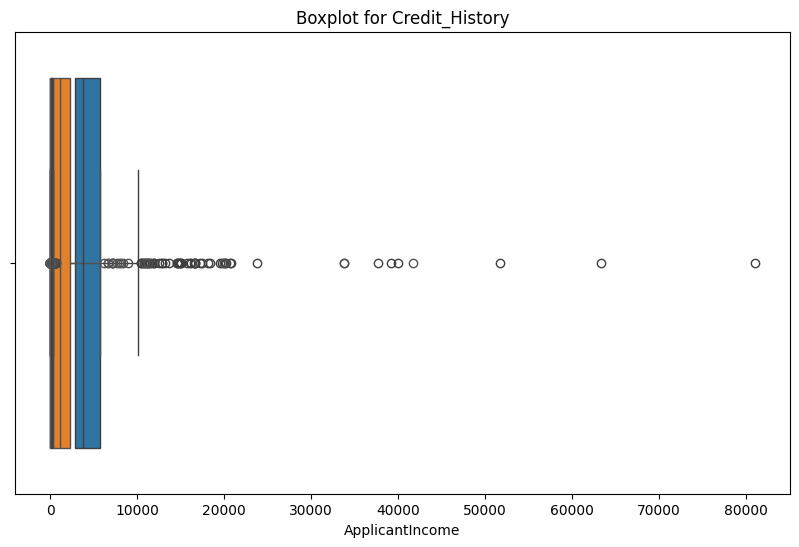

In [34]:
def find_outliers_IQR(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

plt.figure(figsize=(10, 6))
numerical_columns = df.select_dtypes(include=['float64', 'int64'])
for col in numerical_columns.columns:
    outliers = find_outliers_IQR(df, col)
    print(f"Number of outliers in {col}: {len(outliers)}")

    sns.boxplot(x=df[col])
    plt.title(f"Boxplot for {col}")
plt.show()

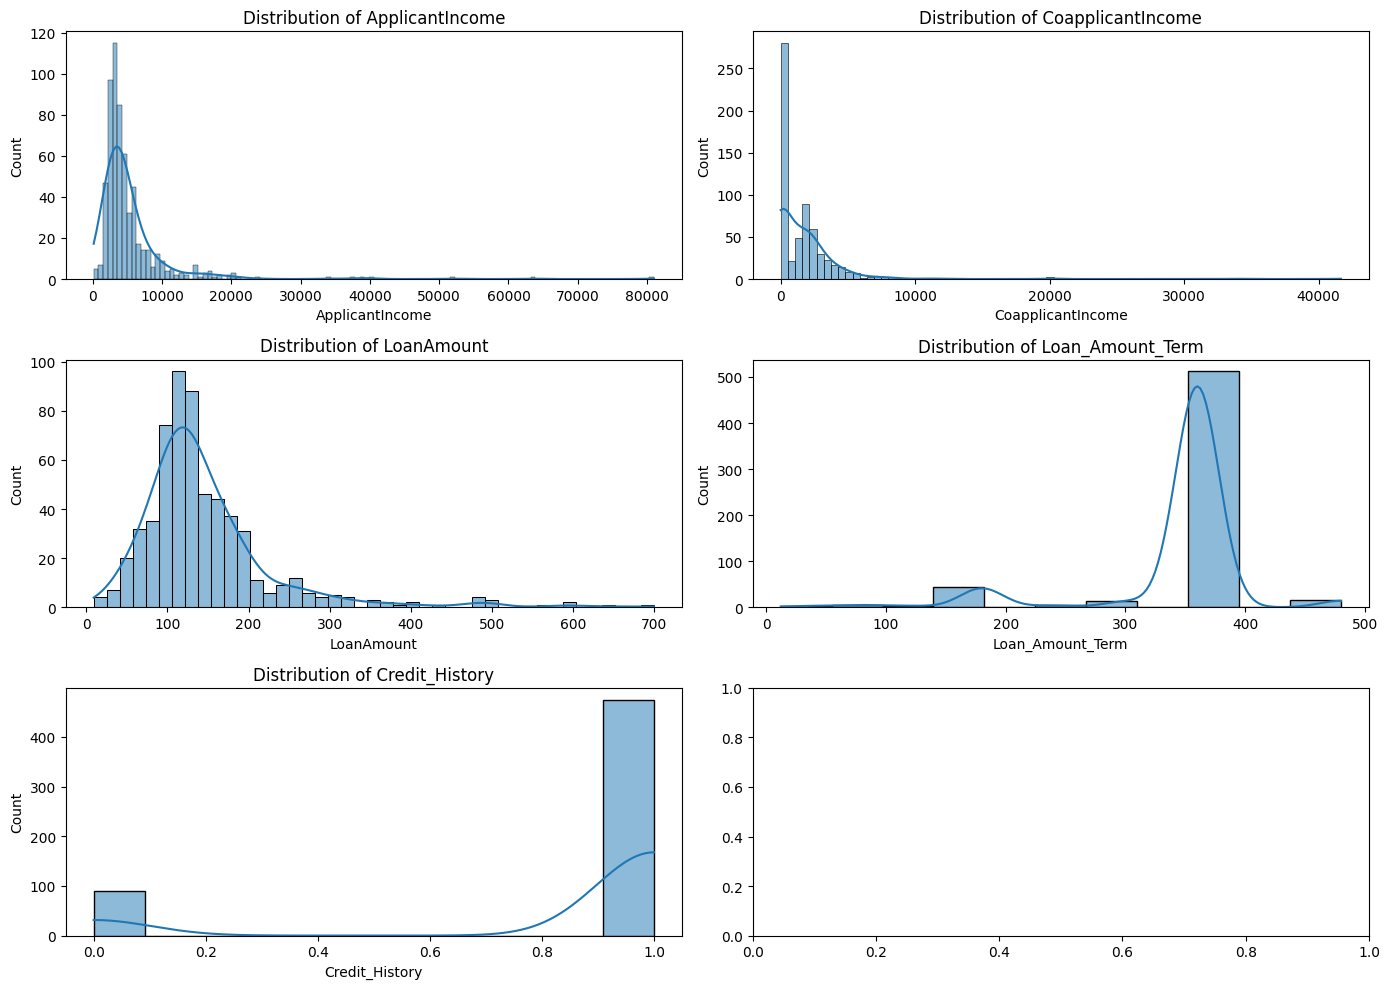

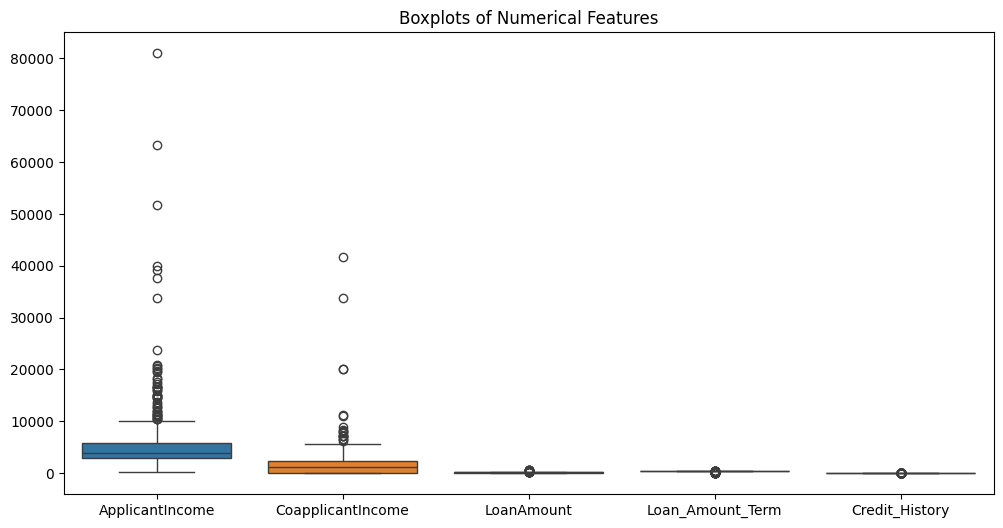

In [20]:
numerical_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.histplot(df[feature].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

plt.tight_layout()

# Boxplots to detect outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numerical_features])
plt.title("Boxplots of Numerical Features")
plt.show()

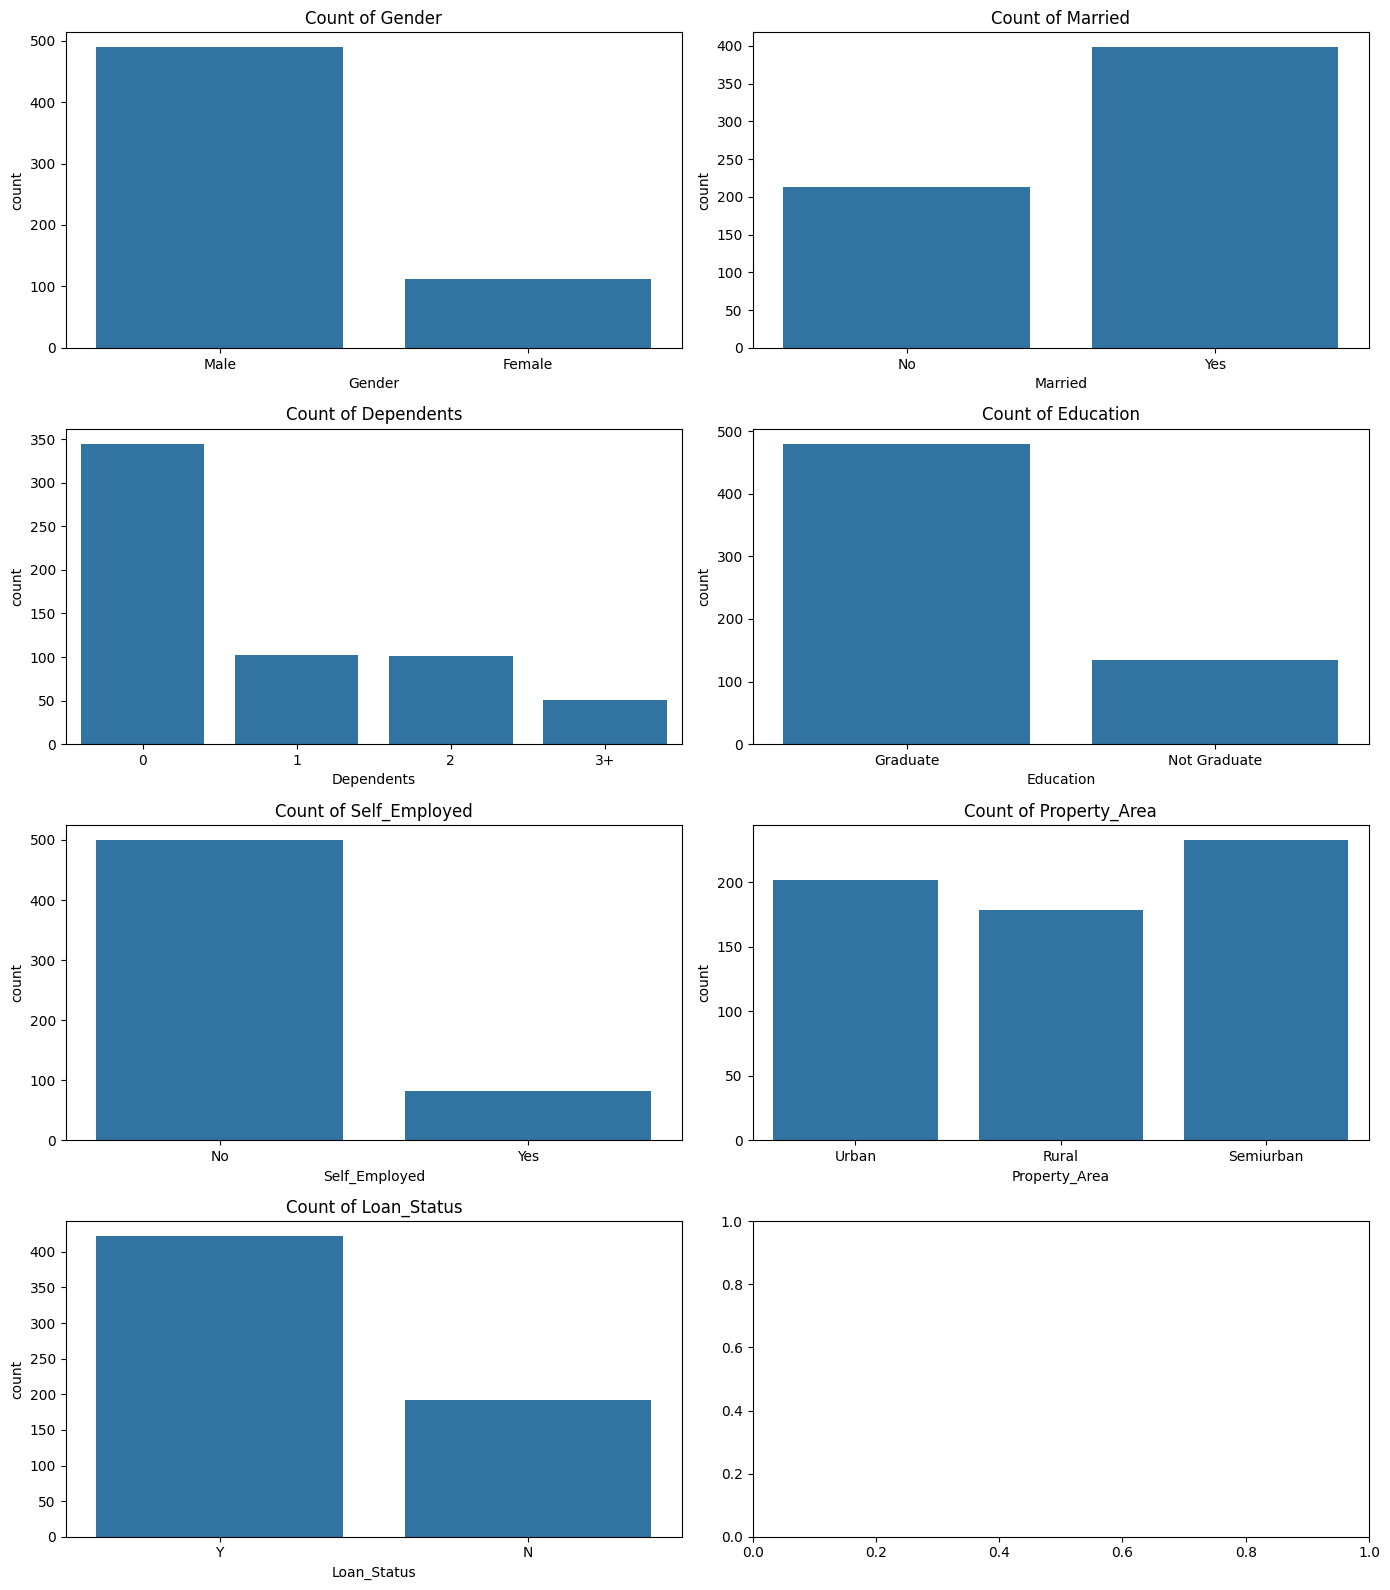

In [21]:
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
fig, axes = plt.subplots(4, 2, figsize=(14, 16))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, data=df, ax=axes[i])
    axes[i].set_title(f'Count of {feature}')

plt.tight_layout()

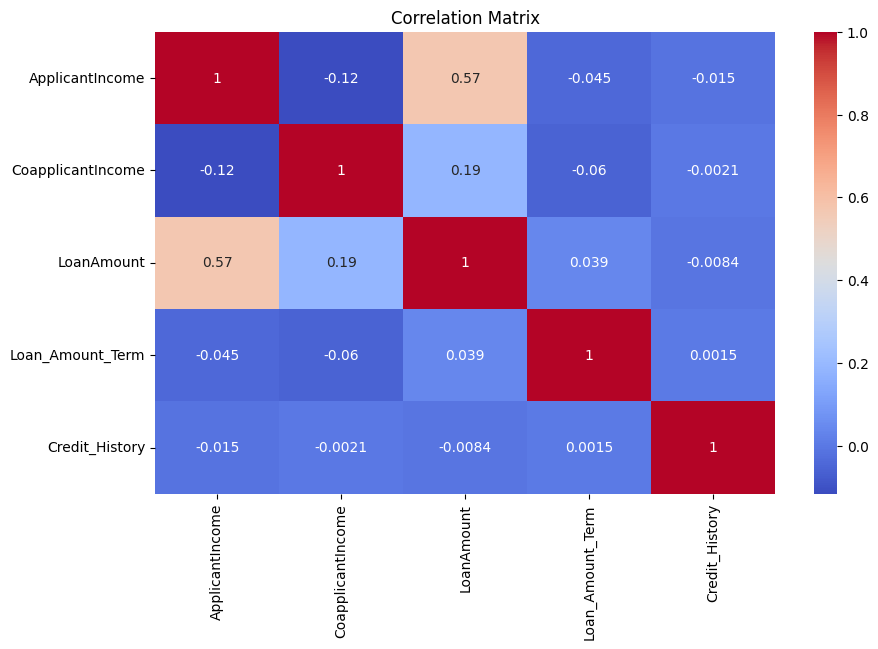

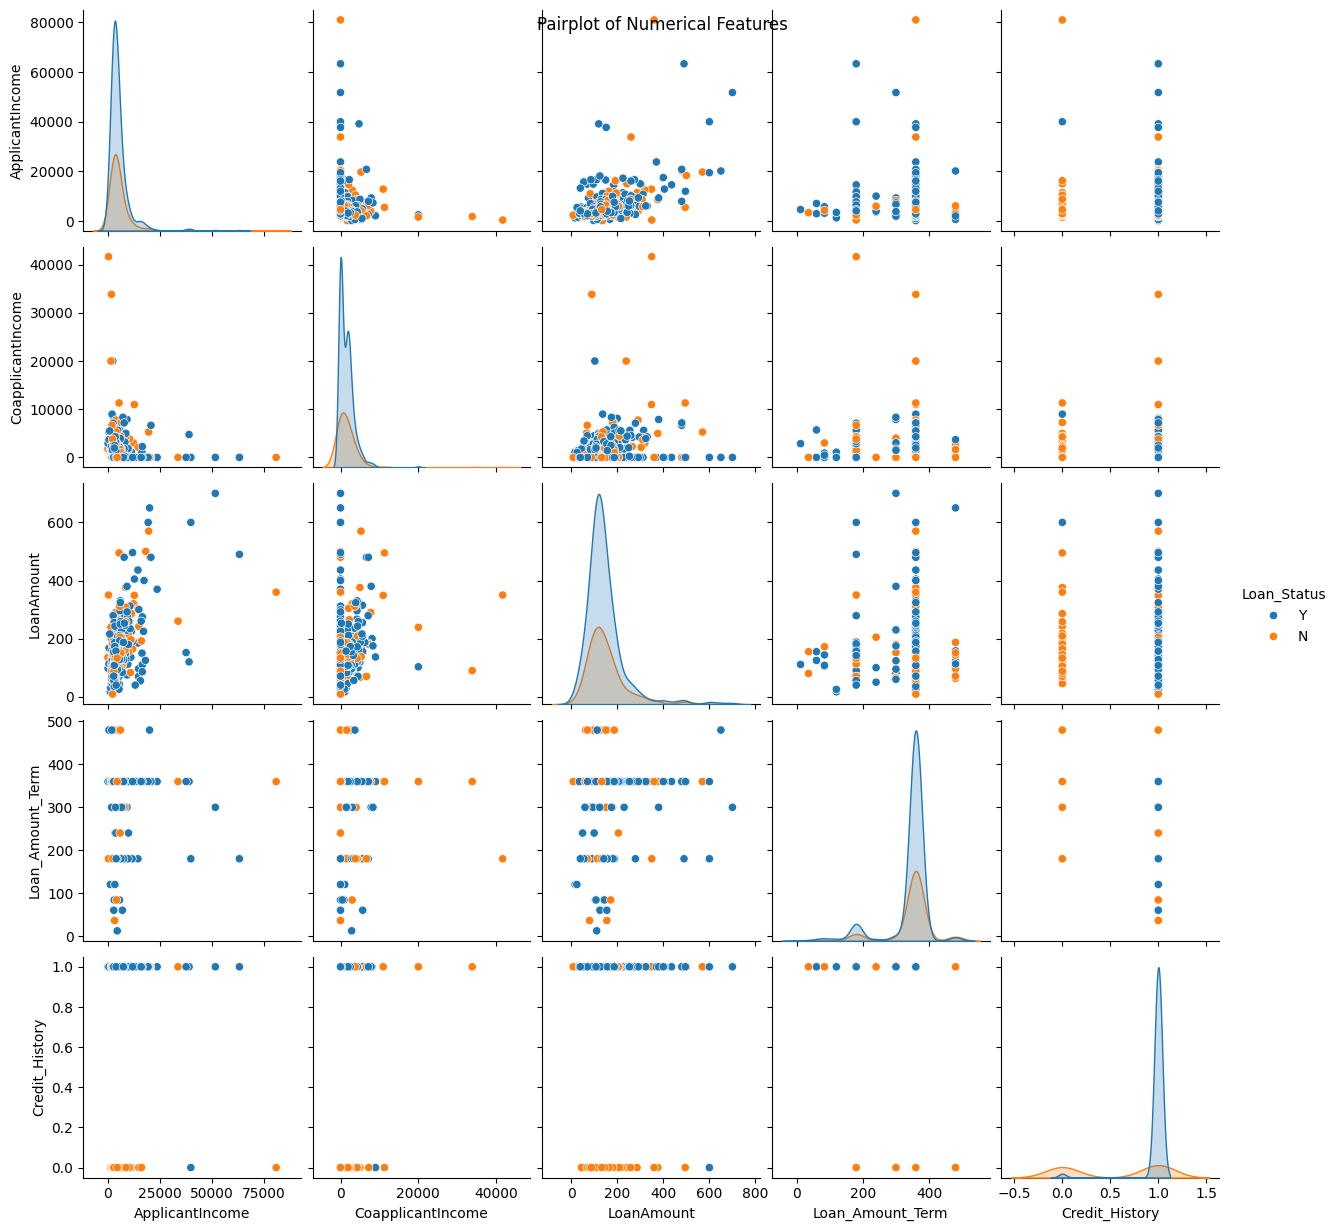

In [22]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Pairplot for selected features to check relationships and clustering
sns.pairplot(df, vars=numerical_features, hue='Loan_Status', diag_kind="kde")
plt.suptitle("Pairplot of Numerical Features")
plt.show()

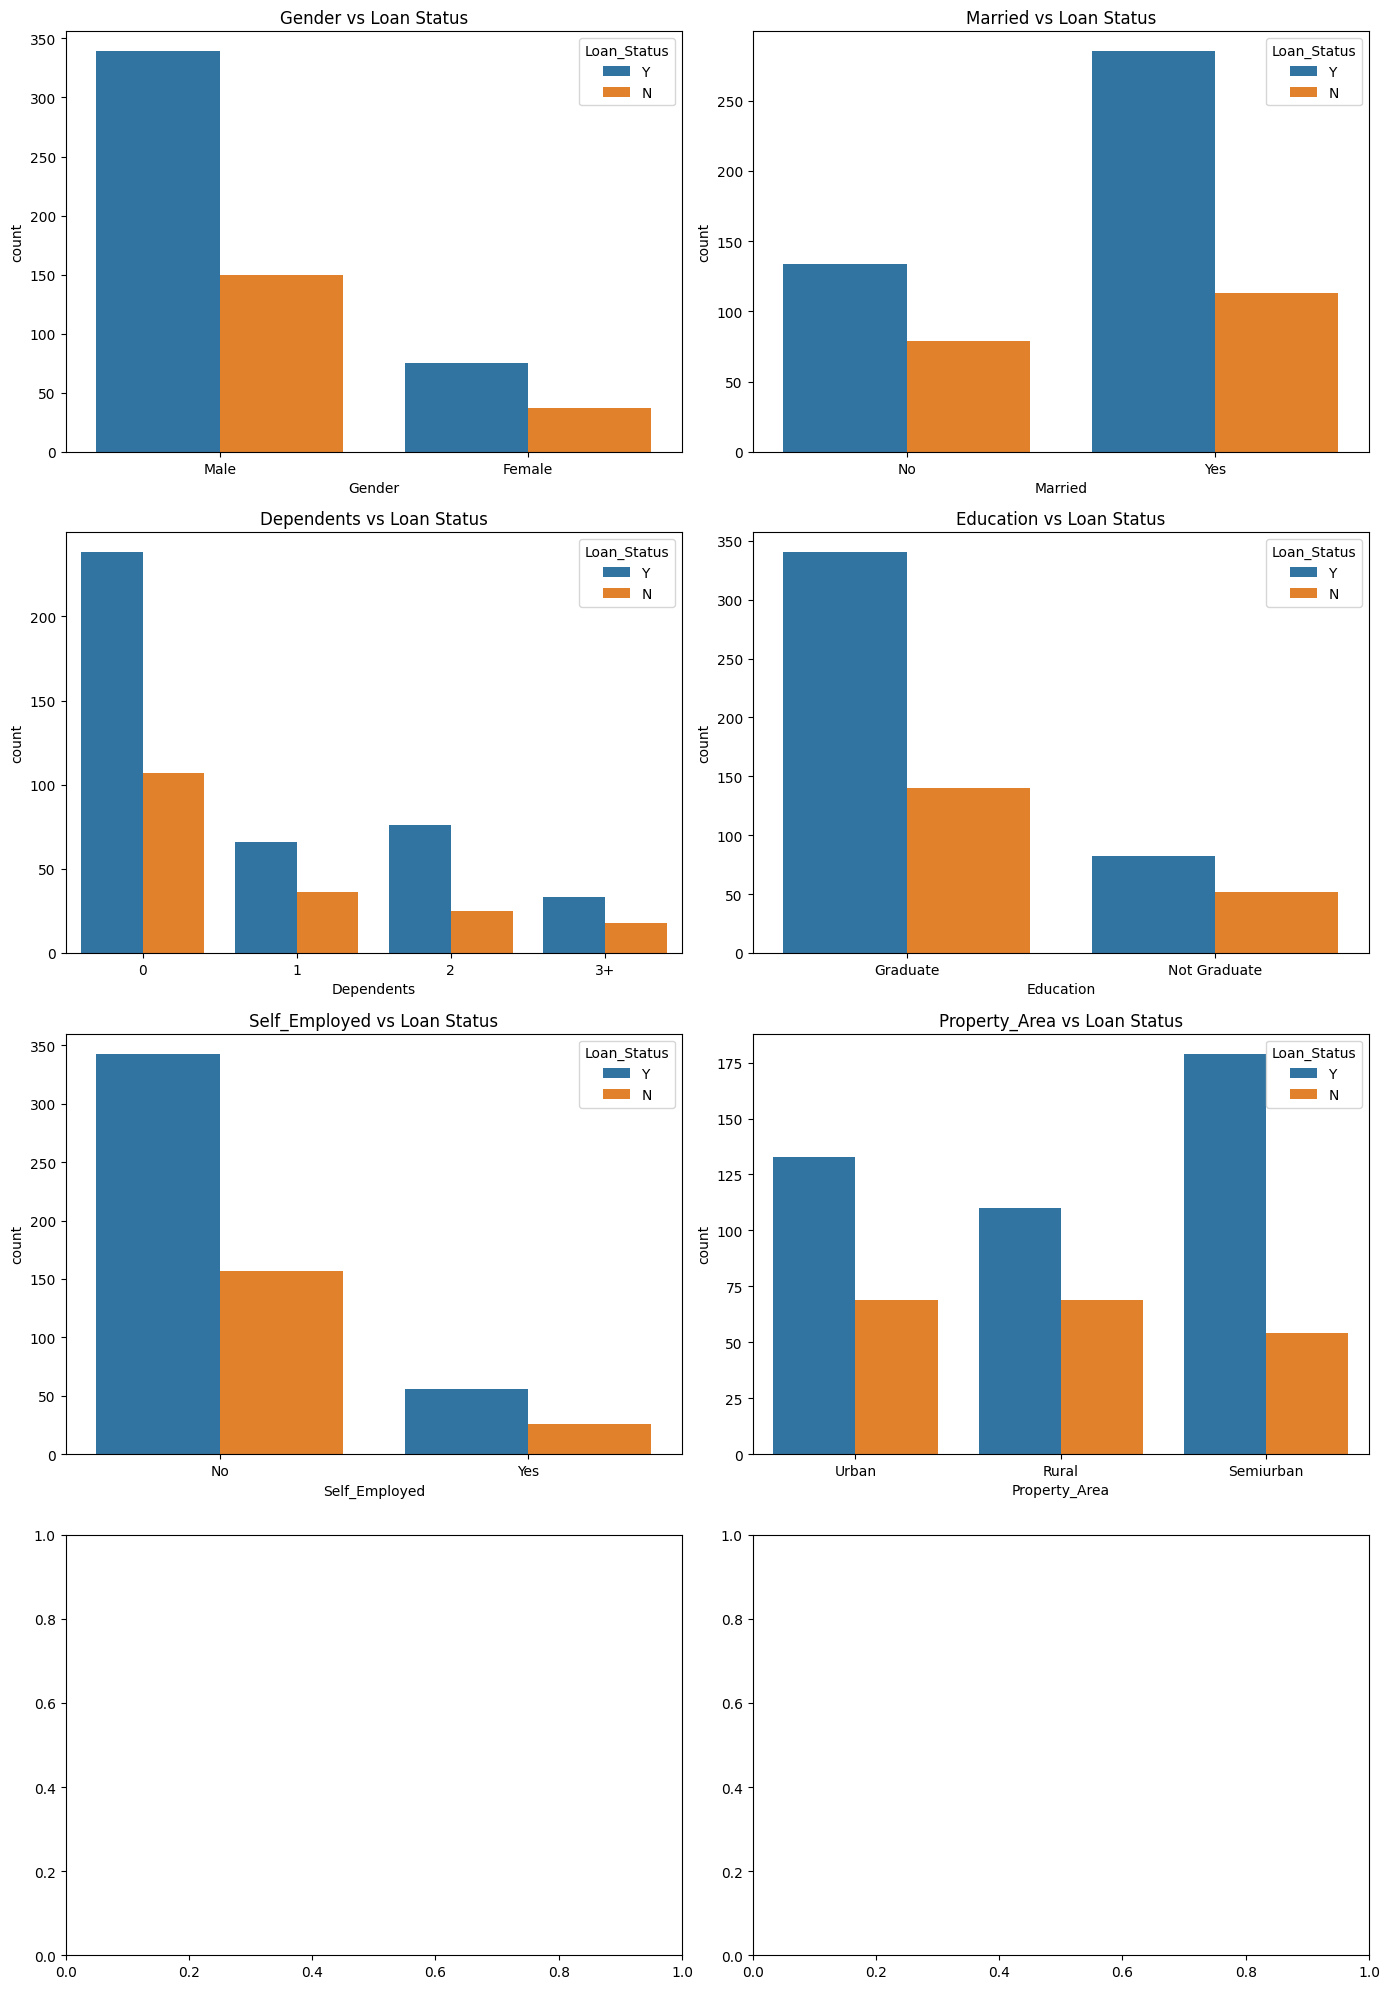

In [23]:
fig, axes = plt.subplots(4, 2, figsize=(14, 20))
axes = axes.flatten()

for i, feature in enumerate(categorical_features[:-1]):  # Exclude Loan_Status
    sns.countplot(x=feature, hue="Loan_Status", data=df, ax=axes[i])
    axes[i].set_title(f'{feature} vs Loan Status')

plt.tight_layout()

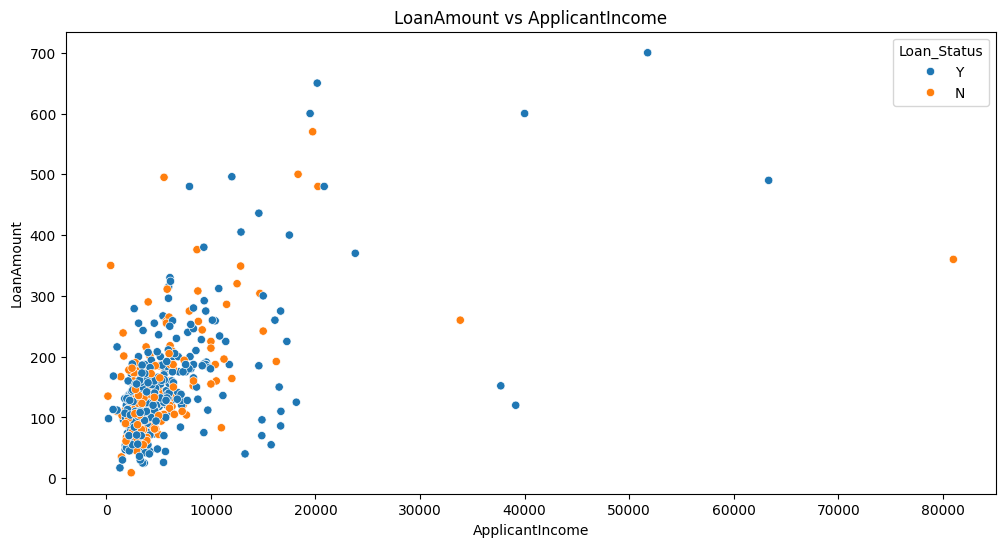

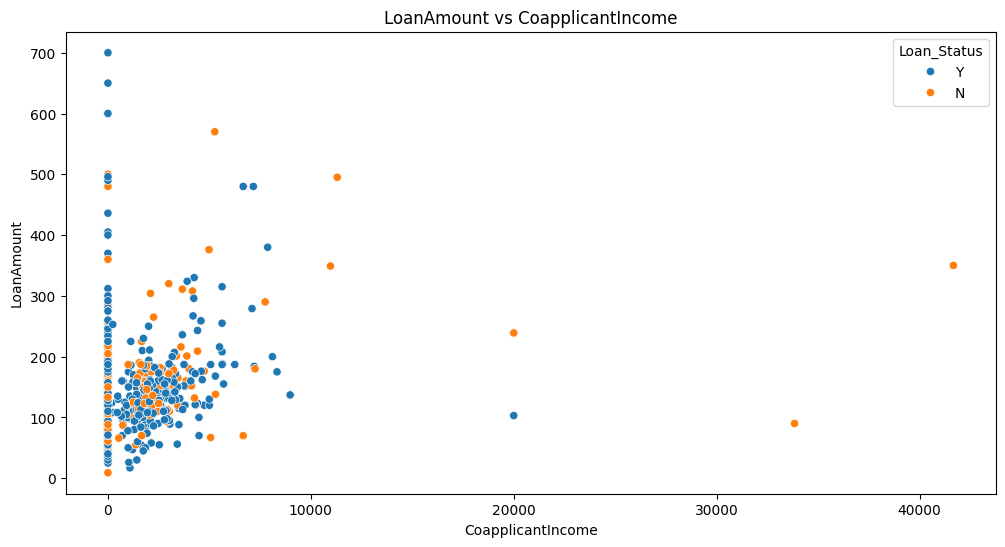

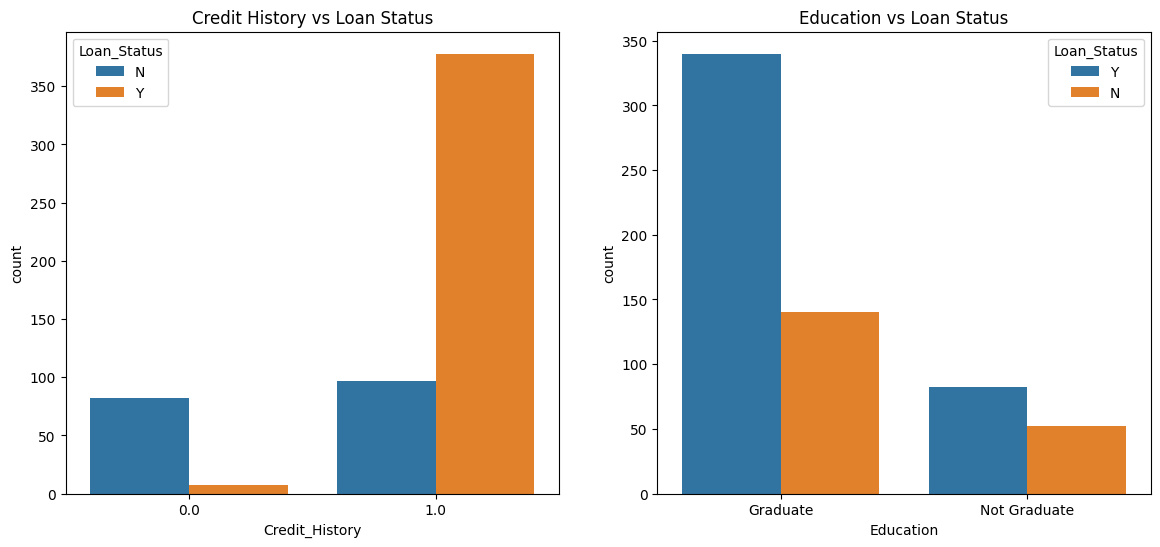

In [24]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='ApplicantIncome', y='LoanAmount', hue='Loan_Status', data=df)
plt.title("LoanAmount vs ApplicantIncome")

plt.figure(figsize=(12, 6))
sns.scatterplot(x='CoapplicantIncome', y='LoanAmount', hue='Loan_Status', data=df)
plt.title("LoanAmount vs CoapplicantIncome")
plt.show()

# Credit History and Education vs Loan Status
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.countplot(x='Credit_History', hue="Loan_Status", data=df, ax=axes[0])
axes[0].set_title("Credit History vs Loan Status")

sns.countplot(x='Education', hue="Loan_Status", data=df, ax=axes[1])
axes[1].set_title("Education vs Loan Status")
plt.show()

In [36]:
df.drop(columns=['Loan_ID'], inplace=True)
df.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [65]:
X = df.drop("Loan_Status", axis=1)
y = df['Loan_Status'].map({'Y': 1, 'N': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((491, 12), (123, 12))

In [66]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

X_train[0]

<1x511 sparse matrix of type '<class 'numpy.float64'>'
	with 12 stored elements in Compressed Sparse Row format>

In [67]:
base_classifier = LogisticRegression(max_iter=1000, random_state=42)

# One-vs-Rest (OvR) classification
ovr_classifier = OneVsRestClassifier(base_classifier)
ovr_classifier.fit(X_train, y_train)
ovr_score = ovr_classifier.score(X_test, y_test)

# One-vs-One (OvO) classification
ovo_classifier = OneVsOneClassifier(base_classifier)
ovo_classifier.fit(X_train, y_train)
ovo_score = ovo_classifier.score(X_test, y_test)

print(f"OvR Accuracy: {ovr_score:.4f}")
print(f"OvO Accuracy: {ovo_score:.4f}")

OvR Accuracy: 0.7886
OvO Accuracy: 0.7886


In [69]:
from sklearn.metrics import classification_report

y_pred_ovr = ovr_classifier.predict(X_test)
y_pred_ovo = ovo_classifier.predict(X_test)

print("OvR Classification Report:\n", classification_report(y_test, y_pred_ovr))
print("\nOvO Classification Report:\n", classification_report(y_test, y_pred_ovo))

OvR Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123


OvO Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123



Step 4: Analysis

Performance Summary

We got the same result for both classifiers since our dataset only has two classes -> Loan_Status = 'Y' and 'N'.

But usually, both methods have the following:

One-vs-Rest (OvR):

- OvR will generally have higher recall as it focuses on distinguishing each class against all others. If the dataset is imbalanced, OvR can suffer because it tries to make a binary decision for each class.

- The accuracy and F1-scores in the OvR classification report provide insights into each class's predictive strength.

One-vs-One (OvO):

- OvO tends to have better precision because it compares each pair of classes independently. It is often more accurate on balanced datasets with multiple classes but can be computationally intensive for large numbers of classes.

- OvO can be beneficial when classes have subtle differences, as it avoids generalization across all classes.